## **Lab 4 - CNN**
- Juan Pablo Solis
- Diego García

#### **Capa Conv2D**
La capa Conv2d trabaja con tensores de cuatro dimensiones que tienen la forma (batch_size, canales, alto, ancho). Sus parámetros más importantes son el número de canales de entrada (in_channels), la cantidad de filtros de salida (out_channels), el tamaño del kernel o filtro (kernel_size), el stride (que es el paso con el que se mueve el filtro), el padding (que rellena los bordes de la imagen) y el uso o no de bias. En las CNN se usa para extraer características de las imágenes, como bordes, texturas y formas, y es una de las capas más básicas y esenciales.

#### **Capa MaxPool2D**
La capa MaxPool2d también recibe tensores en formato (batch_size, canales, alto, ancho). Sus parámetros principales son el kernel_size, el stride y el padding. Lo que hace es reducir el tamaño de los mapas de características seleccionando el valor máximo dentro de cada ventana. Se usa en CNN para hacer la red más eficiente, reduciendo la cantidad de datos pero conservando lo más importante de la imagen, además de ayudar a controlar el sobreajuste.

#### **Capa Avg MaxPool**
La capa AvgPool2d funciona de manera parecida a la de max pooling, también recibe tensores de cuatro dimensiones y tiene parámetros como kernel_size, stride y padding. La diferencia es que en lugar de tomar el valor máximo de la ventana, calcula el promedio. Se utiliza en arquitecturas donde se quiere una reducción de dimensionalidad más “suave”, porque conserva más información del área original, aunque pierde un poco la capacidad de destacar características fuertes como bordes.

#### **Normalizacion de MNIST**
Finalmente, para el dataset MNIST se puede aplicar normalización de diferentes formas. Lo más común es dividir los valores de los píxeles entre 255, para que estén en un rango de 0 a 1. También se puede estandarizar, restando la media y dividiendo entre la desviación estándar del dataset, lo cual hace que los datos tengan media cercana a 0 y varianza 1. Esto ayuda a que el entrenamiento sea más rápido, mejora la estabilidad de la red y reduce el riesgo de que se produzca sobreajuste.

### **Entrenamiento Modelo CNN**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_filters1=32, num_filters2=64, fc_neurons=128):
        super(CNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters1, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv2 = nn.Conv2d(in_channels=num_filters1, out_channels=num_filters2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.fc1 = nn.Linear(num_filters2 * 7 * 7, fc_neurons)
        self.fc2 = nn.Linear(fc_neurons, 10)  

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def train_model(model, optimizer, epochs=3):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        test_accuracies.append(acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Test Acc: {acc:.2f}%")

    
    return train_losses, test_accuracies


#### **Modelo Usando optimizador SSG**

In [21]:
model_sgd = CNN()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)

print("Entrenando con optimizador SGD...")
losses_sgd, acc_sgd = train_model(model_sgd, optimizer_sgd, epochs=3)
evaluate_model(model_sgd)

Entrenando con optimizador SGD...
Epoch 1/3, Loss: 0.2009, Test Acc: 98.00%
Epoch 2/3, Loss: 0.0502, Test Acc: 98.66%
Epoch 3/3, Loss: 0.0340, Test Acc: 99.15%
Accuracy en test: 99.15%


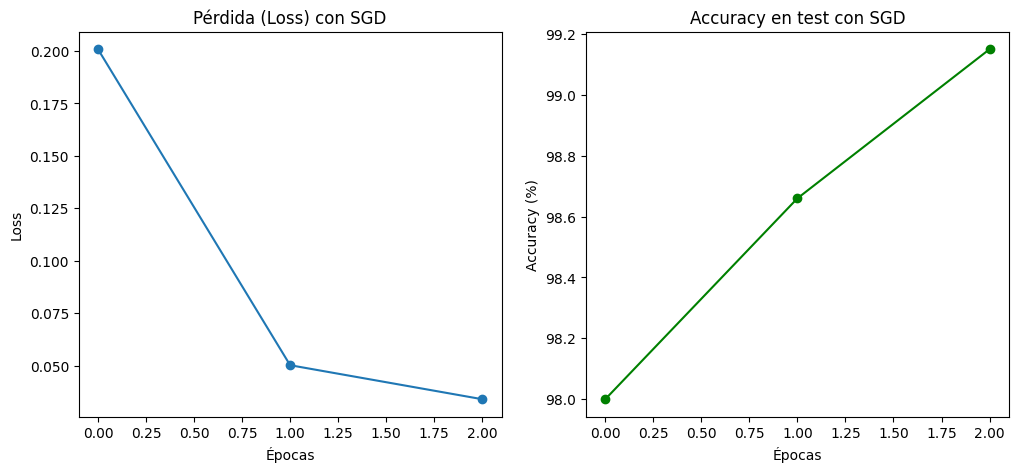

In [22]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(losses_sgd, marker='o')
plt.title("Pérdida (Loss) con SGD")
plt.xlabel("Épocas")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(acc_sgd, marker='o', color='green')
plt.title("Accuracy en test con SGD")
plt.xlabel("Épocas")
plt.ylabel("Accuracy (%)")

plt.show()


Durante el entrenamiento con el optimizador SGD, se observó que la pérdida fue disminuyendo de manera constante en cada época, pasando de 0.2009 en la primera a 0.0340 en la tercera. Esto indica que el modelo logró aprender patrones de los datos de forma eficiente. En cuanto a la precisión sobre el conjunto de prueba, esta comenzó en 98.00% y alcanzó un 99.15% al final de las tres épocas, mostrando una mejora clara y sostenida. Las gráficas confirman este comportamiento: la curva de pérdida desciende rápidamente y la de accuracy crece de forma casi lineal

#### **Modelo Usando optimizador ADAM**

In [23]:
model_adam = CNN()
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

print("Entrenando con optimizador Adam...")
losses_adam, acc_adam = train_model(model_adam, optimizer_adam, epochs=3)
evaluate_model(model_adam)


Entrenando con optimizador Adam...
Epoch 1/3, Loss: 0.1390, Test Acc: 98.66%
Epoch 2/3, Loss: 0.0424, Test Acc: 98.57%
Epoch 3/3, Loss: 0.0293, Test Acc: 98.96%
Accuracy en test: 98.96%


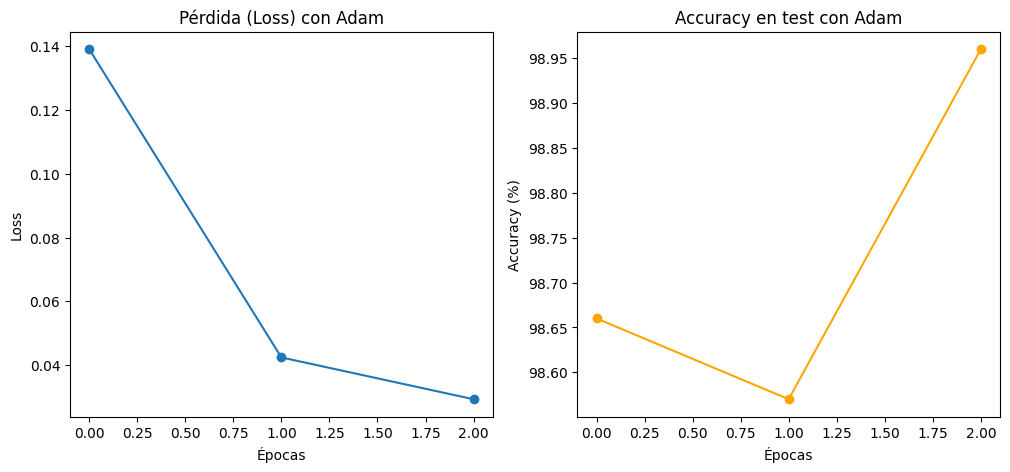

In [24]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(losses_adam, marker='o')
plt.title("Pérdida (Loss) con Adam")
plt.xlabel("Épocas")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(acc_adam, marker='o', color='orange')
plt.title("Accuracy en test con Adam")
plt.xlabel("Épocas")
plt.ylabel("Accuracy (%)")

plt.show()


En el entrenamiento con el optimizador Adam, los resultados mostraron una reducción progresiva de la pérdida, comenzando en 0.1390 en la primera época y llegando hasta 0.0293 en la tercera. Esto confirma que el modelo logró aprender de forma estable durante el proceso. En cuanto a la precisión sobre el conjunto de prueba, los valores se mantuvieron cercanos al 99%, aunque con una pequeña variación entre épocas: inició en 98.66%, bajó levemente a 98.57% en la segunda y finalmente alcanzó 98.96% en la tercera. Las gráficas reflejan claramente esta tendencia: la pérdida disminuye de manera continua, mientras que el accuracy presenta una ligera oscilación antes de mejorar al final. En conclusión, Adam también consiguió un muy buen rendimiento en la clasificación de MNIST, aunque comparado con SGD se nota que la mejora en la precisión fue un poco menos consistente entre épocas.

### **Experimentacion con más filtro y neuronas**

In [25]:
print("Modelo con más filtros y más neuronas en la capa fully connected...")

model_big = CNN(num_filters1=64, num_filters2=128, fc_neurons=256)
optimizer_big = optim.Adam(model_big.parameters(), lr=0.001)

losses_big, acc_big = train_model(model_big, optimizer_big, epochs=3)
evaluate_model(model_big)


Modelo con más filtros y más neuronas en la capa fully connected...
Epoch 1/3, Loss: 0.1044, Test Acc: 98.44%
Epoch 2/3, Loss: 0.0371, Test Acc: 98.88%
Epoch 3/3, Loss: 0.0236, Test Acc: 98.96%
Accuracy en test: 98.96%


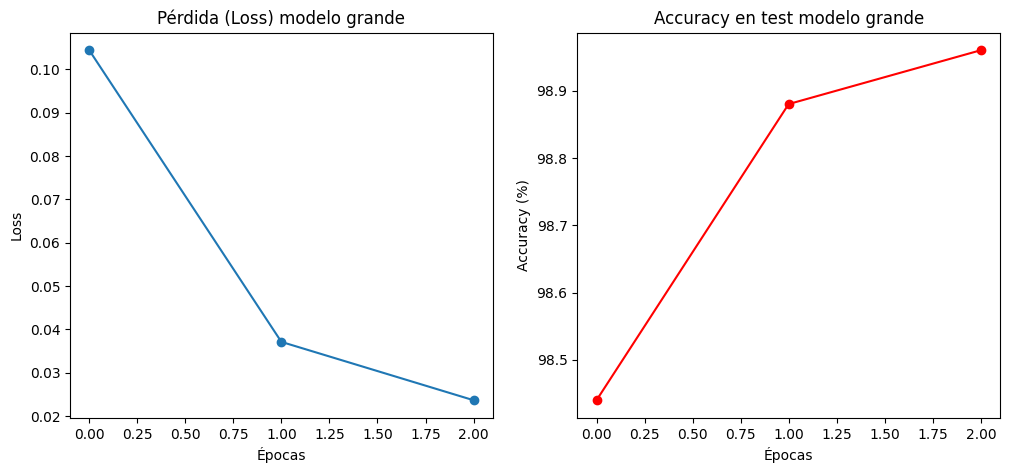

In [26]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(losses_big, marker='o')
plt.title("Pérdida (Loss) modelo grande")
plt.xlabel("Épocas")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(acc_big, marker='o', color='red')
plt.title("Accuracy en test modelo grande")
plt.xlabel("Épocas")
plt.ylabel("Accuracy (%)")

plt.show()


En el experimento con el modelo más grande (mayor número de filtros en las capas convolucionales y más neuronas en la capa totalmente conectada), se observó un comportamiento estable en el entrenamiento. La pérdida inicial fue de 0.1044 y disminuyó hasta 0.0236 en la tercera época, mostrando un aprendizaje progresivo y efectivo. En cuanto al accuracy en el conjunto de prueba, el modelo comenzó con un 98.44% y alcanzó 98.96% al final de las tres épocas, mejorando de manera constante. Las gráficas reflejan esta tendencia: la curva de pérdida desciende de forma continua y la de precisión va en aumento a lo largo del entrenamiento.

### **Mejor modelo del lab anterior**

In [30]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, hidden_layers, activation_fn):
        super(MLP, self).__init__()
        layers = []
        input_size = 784
        for h in hidden_layers:
            layers.append(nn.Linear(input_size, h))
            layers.append(activation_fn())
            input_size = h
        layers.append(nn.Linear(input_size, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.model(x)


In [32]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [33]:
import torch.optim as optim
import torch.nn as nn

# Configuración del laboratorio pasado
hidden_layers = [256, 128]
activation_fn = nn.Tanh
mlp_model = MLP(hidden_layers=hidden_layers, activation_fn=activation_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Entrenamiento
for epoch in range(15):
    train(mlp_model, train_loader, optimizer, criterion, device)
    acc = test(mlp_model, test_loader, device)
    print(f"Epoch {epoch+1}/15, Test Accuracy: {acc*100:.2f}%")


Epoch 1/15, Test Accuracy: 96.43%
Epoch 2/15, Test Accuracy: 96.81%
Epoch 3/15, Test Accuracy: 97.18%
Epoch 4/15, Test Accuracy: 97.34%
Epoch 5/15, Test Accuracy: 97.03%
Epoch 6/15, Test Accuracy: 97.56%
Epoch 7/15, Test Accuracy: 97.59%
Epoch 8/15, Test Accuracy: 97.41%
Epoch 9/15, Test Accuracy: 97.67%
Epoch 10/15, Test Accuracy: 97.36%
Epoch 11/15, Test Accuracy: 97.56%
Epoch 12/15, Test Accuracy: 97.69%
Epoch 13/15, Test Accuracy: 97.62%
Epoch 14/15, Test Accuracy: 97.48%
Epoch 15/15, Test Accuracy: 97.62%


In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def get_confusion_matrix_tanh(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return confusion_matrix(all_labels, all_preds)


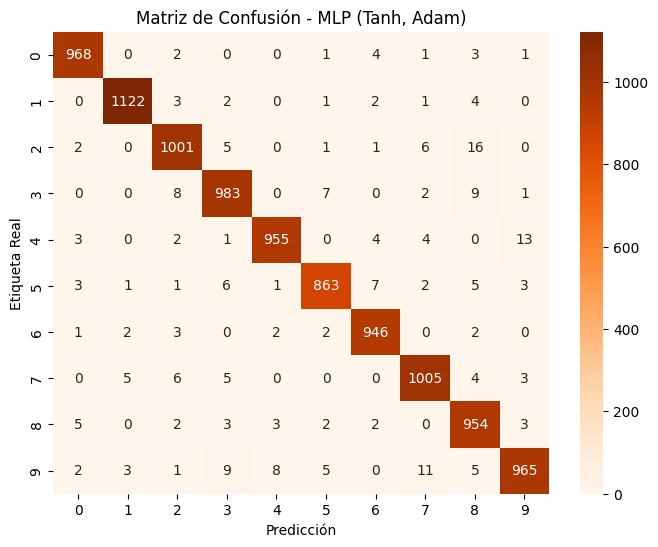

In [37]:
cm_mlp = get_confusion_matrix_tanh(mlp_model, test_loader, device)

plt.figure(figsize=(8,6))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Oranges", 
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión - MLP (Tanh, Adam)")
plt.show()


In [28]:
def get_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    return cm


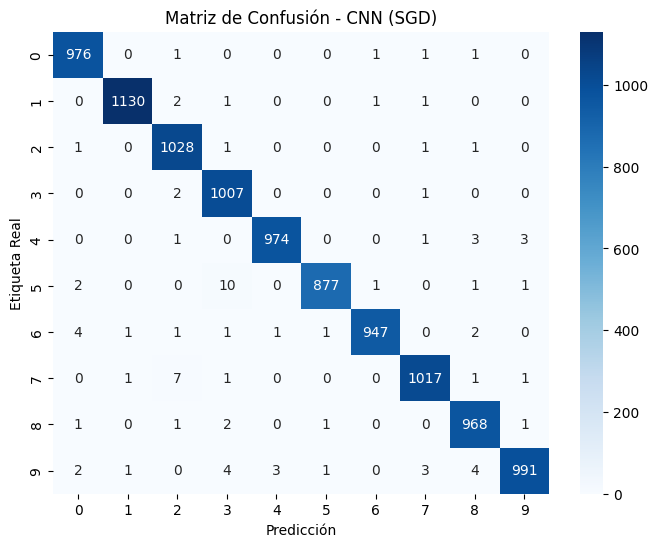

In [ ]:
cm_cnn = get_confusion_matrix(model_sgd, test_loader)

plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión - CNN (SGD)")
plt.show()


### **Comparacion con el lab anterior**

#### **¿Cuál de las dos arquitecturas obtuvo mejor rendimiento en general?**
La red CNN obtuvo un rendimiento superior en general, alcanzando un accuracy de 99.15%, mientras que el MLP logró un máximo de 97.62%. Una diferencia que para un dataset tan grande si es significativa.

#### **¿Qué red alcanzó mayor accuracy en relación con la cantidad de parámetros utilizados?**
Si la cantidad de parametros se toma para la eficiencia final, entonces el MLP tuvo un mejor desempeño. Esto debido a que usa casi la mitad de parametros que el CNN. Por lo tanto, si se cuentan con menos recursos, el MLP es una mejor opción, pero si lo más importante es la precisión final, es mejor el CNN.

#### **Grafiquen y comparen la matriz de confusión multiclase para ambos modelos**
En la matriz de confusión del MLP, se observan más errores distribuidos por toda la matriz, como el 5 confundido con 3, el 9 confundido con 4 y 8, y algunas confusiones entre el 2 y el 7.
En cambio, la matriz de la CNN está mucho más concentrada en la diagonal principal, lo que significa que cometió menos errores. Sin embargo, los errores son más puntuales y pequeños, (lo que hace lógica con las métricas), cono el 5 con el 3 o el 8.

#### **Analicen similitudes y diferencias en los errores de clasificación.**
Ambos modelos tienden a confundirse en dígitos visualmente parecidos, lo cual es un patrón común en MNIST. Sin embargo, en la CNN la cantidad de estos errores fue mucho menor, mientras que en el MLP los errores aparecen con más frecuencia y en más clases. Esto evidencia que el MLP tiene dificultades para separar representaciones de dígitos similares, mientras que la CNN logra generalizar mejor gracias a la extracción de características locales. Por lo tanto, la ambiguedad en la escritura manual afecta a ambos modelos, pero el uso de las convoluciones ayuda a detacatar diferencias más mínimas.

#### **Propongan explicaciones sobre los factores que influyen en esos resultados.**
- La CNN reconoce patrones locales (curvas, bordes o cruces) dentro de las imagenes. Con esto puede distinguir entre detalles más pequeños que el MLP. Esto, porque, este último pierde algo de información al momento de pixelear la imagen.
- La CNN está organizada de forma que los filtros comparten información entre ellos gracias a los parámetros que utiliza. Esto le da más poder de detección. La MLP tiene menos parámetros, distribuidos de una forma menos ineficiente pero sus conexiones son independientes.
- La MLP se entrenó con 15 épocas, mientras que la CNN solo en 3. Esto demuestra que CCN puede llegar más rápido al punto de convergencia en este tipo de casos.